## Import labels

In [50]:
import numpy as np

import matplotlib.pyplot as plt
import utils

from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist
from os import listdir

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier

In [51]:
data_dir = './data/'
img_name = listdir(data_dir) 
img_name=img_name[:-1]
print(img_name)

['2019_04_18_M', '2019_05_03_M', '2019_05_08_M', '2019_05_18_M', '2019_05_28_M', '2019_06_07_M', 'label']


In [52]:
bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']

def get_dataset(data_dir, bands):
    labels = []
    data = []
    img_name = listdir(data_dir)[:-1]
    sizes= []
    for e in img_name : 
        if e!='label':
            data_im, label_im = utils.get_batch(bands, e, all = False)
            sizes.append(data_im.shape[0:2])
            flatten_labels = label_im.flatten()
            flatten_data = [data_im[:,:,i].flatten() for i in range(len(bands))]
            a_concat = np.zeros((flatten_data[0].shape[0],len(bands)))
            for i in range(0, len(flatten_data)):
                a_concat[:,i] = flatten_data[i]
            for k in range(flatten_data[0].shape[0]):
                data.append(a_concat[k])
            for e in flatten_labels:
                labels.append(e)

    return data, labels, sizes
            
    

In [53]:
bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']
data_images, labels_images, sizes_images = get_dataset(data_dir, bands)

## Generating data from Basile's codes

In [54]:
patch_list, label_list = utils.get_simplastic_v1()
del patch_list[5]
del label_list[5]
print(len(patch_list), len(label_list) ,patch_list[0].shape)
nbands = patch_list[0].shape[2]
print(nbands)

67 67 (60, 70, 12)
12


In [55]:
data_generated, labels_generated, sizes = get_dataset_from_table(patch_list, label_list, nbands)
print("Len list data " + str(len(data_generated)))
print("Len list labels " + str(len(labels_generated)))

Len list data 281400
Len list labels 281400


## KNN Classifier

#### Create Training and Testing datasets

In [56]:
from sklearn.model_selection import train_test_split
## We split the dataset into a training and testing set with a ration of 30%

X_train,X_test,y_train,y_test = train_test_split(data_images,labels_images,
                                                 test_size=0.35,random_state=42, stratify=labels_images)

### Faire attention à la proportion de plastique dans les training et testing sets


In [57]:
print(" Taille Training Set = " + str(len(y_train))+ "\n Taille Testing Set = " + str(len(y_test)))

 Taille Training Set = 61378
 Taille Testing Set = 33050


#### Finding the best K 

In [58]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

In [59]:
#Setup arrays to store training and test accuracies
neighbors = [2,3,4,5,8,10,15,20]
train_recall =np.empty(len(neighbors))
test_recall = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    print(k)
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute recall on the training set
    train_recall[i] = metrics.recall_score(y_train, knn.predict(X_train))
    
    #Compute recall on the test set
    test_recall[i] = metrics.recall_score(y_test, knn.predict(X_test)) 

2
3
4
5
8
10
15
20


On utilise le rappel car il est plus pertinent dans notre étude. 

#### Plot the result

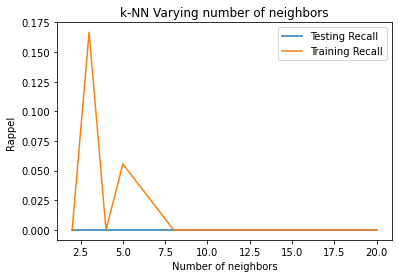

In [60]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_recall, label='Testing Recall')
plt.plot(neighbors, train_recall, label='Training Recall')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Rappel ')
plt.show()

#### Create the best Classifier using the best k

In [61]:
#Setup a knn classifier with k neighbors
best_k= 3
knn = KNeighborsClassifier(n_neighbors=20)

#Fit the model
knn.fit(X_train,y_train)

best_acc = int(knn.score(X_test,y_test) *100) /100

print("The best accuracy is = " + str(best_acc)) ## Les resulats sont à prendre avec du recul


The best accuracy is = 0.99


Meme si les resultats semblent très bons ce n'est pas le cas du tout. En effet, la proportion de  pixels qui ne sont pas du plastique est bien bien plus importante que la proportion de plastique ce qui fausse grandement les resultats. 

In [62]:
y_predict = knn.predict(X_test) ### Testons sur les données de test

In [63]:
cnt_TP = 0
cnt_FP = 0
cnt_FN = 0
cnt_Positifs = 0
for i in range(len(y_predict)) :
    if y_predict[i] == 1 :
        if y_test[i] == 1 :
            cnt_TP+=1
        else :
            cnt_FP+= 1
    if y_test[i] == 1 :
        cnt_Positifs+=1
        if y_predict[i] != 1 :
            cnt_FN+=1

In [64]:
print("Nombre de Pixels Vrais Positifs = " + str(cnt_TP))
print("Nombre de Pixels Faux Positifs = " + str(cnt_FP))
print("Nombre de Pixels Faux Negatifs = " + str(cnt_FN))
print("Nombre de Pixels Positifs = " + str(cnt_Positifs))
print("F1 score = " + str(f1_score(y_test, y_predict)))
print("Accuracy = " + str(metrics.accuracy_score(y_test, y_predict)))
print("recall = " + str(metrics.recall_score(y_test, y_predict)))

Nombre de Pixels Vrais Positifs = 0
Nombre de Pixels Faux Positifs = 0
Nombre de Pixels Faux Negatifs = 10
Nombre de Pixels Positifs = 10
F1 score = 0.0
Accuracy = 0.999697428139183
recall = 0.0


#### Let's Plot the images 

In [65]:
y_predict = knn.predict(data_images) ### Prediction sur l'ensemble des données même les données test !!!!

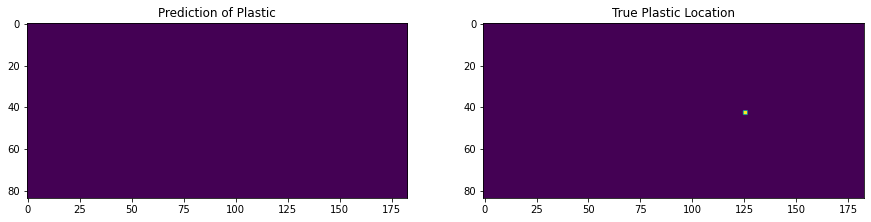

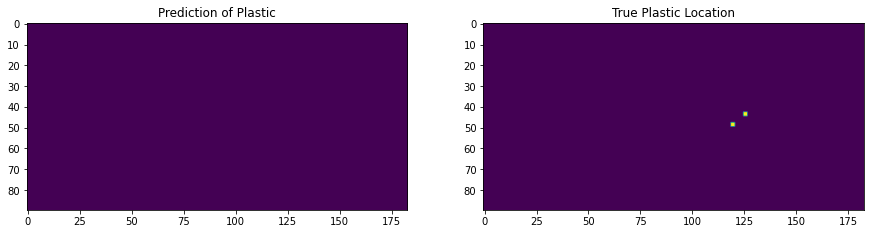

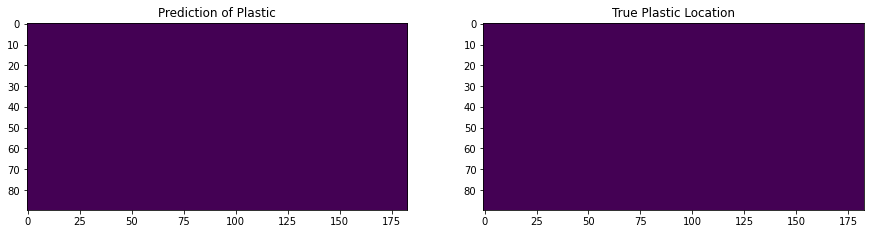

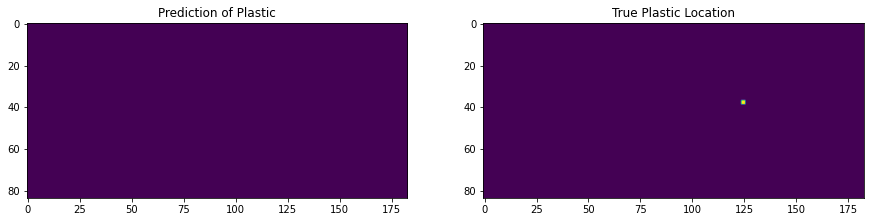

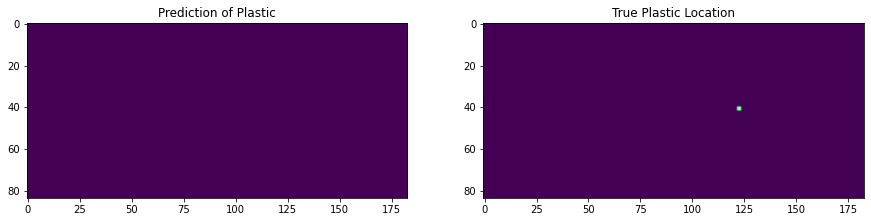

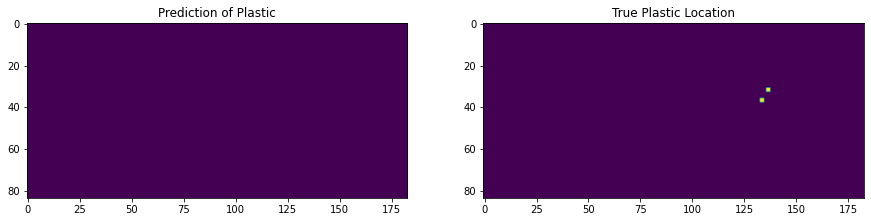

In [70]:
i = 0
for s in sizes_images:
    y_predict_array = np.array(y_predict[i:i+s[0]*s[1]])
    y_true = np.array(labels_images[i:i+s[0]*s[1]])
    
    f = plt.figure(figsize=(15,15))
    f.add_subplot(1,2, 1)
    plt.title("Prediction of Plastic")
    plt.imshow(y_predict_array.reshape(s))
    
    f.add_subplot(1,2, 2)
    
    plt.title("True Plastic Location")
    plt.imshow(y_true.reshape(s))
    plt.show(block=True)

    
    i+=s[0]*s[1]

A noté qu'ici les données sont mélangées : il y a des données de test et des données d'entrainement. J'ai tenu quand même à afficher les données pour avoir un aperçu visuel de l'efficacité de l'algorithme. Efficacité clairement à remettre en question.

## Naïve Bayes Classifier

In [71]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB 
gnb = MultinomialNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (len(X_test), (y_test != y_pred).sum()))

Number of mislabeled points out of a total 33050 points : 10


In [72]:
cnt_TP = 0
cnt_FP = 0
cnt_FN = 0
cnt_Positifs = 0
for i in range(len(y_pred)) :
    if y_pred[i] == 1 :
        if y_test[i] == 1 :
            cnt_TP+=1
        else :
            cnt_FP+= 1
    
    if y_test[i] == 1 :
        cnt_Positifs+=1
        if y_pred[i] != 1 :
            cnt_FN+=1

In [73]:
print("Nombre de Pixels Vrais Positifs = " + str(cnt_TP))
print("Nombre de Pixels Faux Positifs = " + str(cnt_FP))
print("Nombre de Pixels Faux Negatifs = " + str(cnt_FN))
print("Nombre de Pixels Positifs = " + str(cnt_Positifs))

Nombre de Pixels Vrais Positifs = 0
Nombre de Pixels Faux Positifs = 0
Nombre de Pixels Faux Negatifs = 10
Nombre de Pixels Positifs = 10


In [74]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[33040,     0],
       [   10,     0]], dtype=int64)

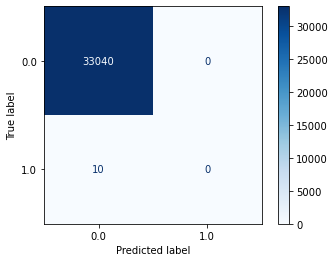

<Figure size 2160x1440 with 0 Axes>

In [75]:
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gnb, X_test, y_test, cmap=plt.cm.Blues,)  
plt.figure(figsize=(30,20))
plt.show()  

Commme la montre ici la matrice de confusion, l'agorithme est extraiement mauvais. 

#### Conclusion

Ces techniques ne sont pas à abandonnées. Elles ont montré leur efficacité dans plusieurs écrits que l'on a pu trouver, leur point commun : ils avaient accès à un nombre de données plus importants. En effet, la trop faible proportion de plastique dans les images ne permet pas aux algorithmes d'établir des critères discriminants pour classer les pixels.  

Il s'agira à l'avenir d'essayer d'acquérir plus de données pour pouvoir faire de l'apprentissage supervisé dans de meilleure condition. 